# Lesson 2

## Purpose

In this lesson we will learn how to load an existing model and look inside the column.

## Change langmuir, bound and looks at beads

## Standard imports

In [1]:
#from IPython.core.display import display, HTML
from IPython.display import display, HTML, clear_output
display(HTML("<style>.container { width:100% !important; }</style>"))

#Python path library support
from pathlib import Path

#python numeric library
import numpy

#scientific library for python
import scipy

#pandas is python library for data analysis
import pandas

#make the plots interactive
#%matplotlib inline

#python plotting library
import matplotlib.pyplot as plt

#cadet python interface
from cadet import Cadet

#jupyter widget support
from ipywidgets import interact
import ipywidgets as widgets

## Setup CADET path

In order to run examples we need to specify where CADET is.

On Windows just change the cadet_bin_path to the bin directory of CADET

On Linux you need to change the cadet_bin_path and also change cadet-cli.exe to cadet-cli on the following line.

In [2]:
#put in the path to the bin folder
cadet_bin_path = Path(r"C:\Users\kosh_000\cadet_build\CADET\VCPKG\bin")

cadet_path = cadet_bin_path / "cadet-cli.exe"

if cadet_path.exists():
    print("CADET was found. Continue to the next step.")
    Cadet.cadet_path = cadet_path.as_posix()
else:
    print('CADET could not be found. Please check the bin path')

CADET was found. Continue to the next step.


## Create lesson folders and create lesson variables

This will create all the lesson folders we need and make it easier to refer to previous lessons

In [3]:
#set this to a directory on your computer where the cadet tutorial files can be saved
cadet_tutorial = Path('F:/temp/cadet_tutorial')
lesson_1 = cadet_tutorial / "lesson_1"
lesson_2 = cadet_tutorial / "lesson_2"
lesson_2.mkdir(exist_ok = True, parents=True)

## Load an existing model and modify it

In this example we will load the model from Lesson 1 and then change it from LUMPED_RATE_MODEL_WITH_PORES to GENERAL_RATE_MODEL so that we can look inside the particles

CompletedProcess(args=['C:/Users/kosh_000/cadet_build/CADET/VCPKG/bin/cadet-cli.exe', 'F:/temp/cadet_tutorial/lesson_2/grm_example/example.h5'], returncode=0, stdout=b'', stderr=b'')
Simulation completed successfully


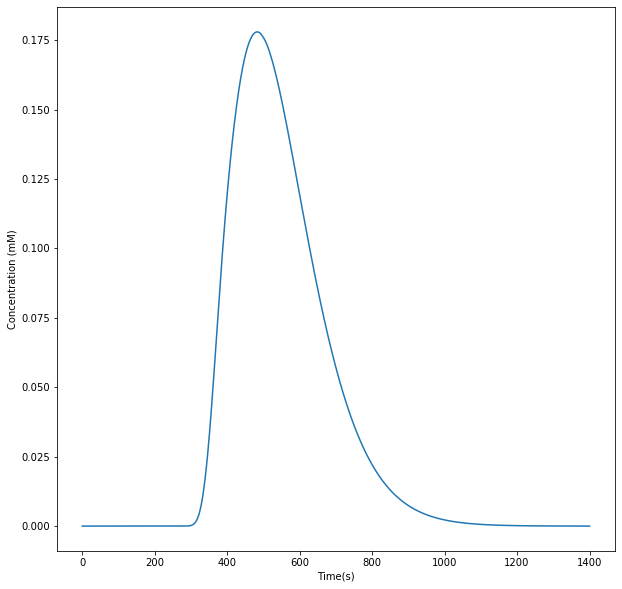

In [4]:
#simple_grm model
grm_example = lesson_2 / "grm_example"
grm_example.mkdir(exist_ok = True)

simple_grm = Cadet()

#load a previous simulation to use as the base for the new one
simple_grm.filename = (lesson_1 / "simple_example" / 'example.h5').as_posix()
simple_grm.load()

#give a filename for where the simulation should be saved
simple_grm.filename = (grm_example / 'example.h5').as_posix()

#take the original simulation and change just the parts we need

#create a column
simple_grm.root.input.model.unit_001.unit_type = 'GENERAL_RATE_MODEL'
simple_grm.root.input.model.unit_001.film_diffusion = [2e-7,]
simple_grm.root.input.model.unit_001.par_diffusion = [1e-11,]
simple_grm.root.input.model.unit_001.par_surfdiffusion = [0.0,]

#discretization column settings
simple_grm.root.input.model.unit_001.discretization.npar = 10
simple_grm.root.input.model.unit_001.discretization.par_disc_type = 'EQUIDISTANT_PAR'

#set what values get saved
simple_grm.root.input['return'].unit_000.write_solution_bulk = 1
simple_grm.root.input['return'].unit_000.write_solution_flux = 0
simple_grm.root.input['return'].unit_000.write_solution_inlet = 1
simple_grm.root.input['return'].unit_000.write_solution_outlet = 1
simple_grm.root.input['return'].unit_000.write_solution_particle = 1

simple_grm.root.input['return'].unit_001 = simple_grm.root.input['return'].unit_000
simple_grm.root.input['return'].unit_002 = simple_grm.root.input['return'].unit_000

#set the times that the simulator writes out data for
simple_grm.root.input.solver.user_solution_times = numpy.linspace(0, 1400, 1401)

#solver settings
simple_grm.root.input.solver.sections.section_times = [0.0, 50.0, 1400.0]

#save the simulation
simple_grm.save()

#run the simulation
data = simple_grm.run()

print(data)

if data.returncode == 0:
    print("Simulation completed successfully")
    
    #load the data from the simulation so we can view the results
    simple_grm.load()
    
    #plot the simulation
    plt.figure(figsize=[10,10])
    plt.plot(simple_grm.root.output.solution.solution_times,
        simple_grm.root.output.solution.unit_001.solution_outlet_comp_000)
    plt.xlabel('Time(s)')
    plt.ylabel('Concentration (mM)')
    
    #write the chromatogram data out to a csv file
    data = pandas.DataFrame([simple_grm.root.output.solution.solution_times,
                        simple_grm.root.output.solution.unit_001.solution_outlet_comp_000]).transpose()
    data.to_csv((grm_example / 'example.csv').as_posix(), index=False, header=False)
    
else:
    print("Simulation failed")

## Look at the bulk concentration inside the column over time

Set write_solution_bulk = 1 to write out the liquid phase concentration between the particles along the entire column at all time points.

You can read this using

```python
solution_bulk[time, axial position, component]
```


In [5]:
ymax = numpy.max(simple_grm.root.output.solution.unit_001.solution_bulk[:])

def graph_column(time=0):
    position = list(range(simple_grm.root.input.model.unit_001.discretization.ncol))
    values = simple_grm.root.output.solution.unit_001.solution_bulk[time, :, 0]
    plt.figure(figsize=[15,5])
    plt.plot(position, values)
    plt.ylim(0, ymax)
    plt.xlabel('Column Length')
    plt.ylabel('Concentration (mM)')

interact(graph_column, time=widgets.IntSlider(min=0, max=len(simple_grm.root.output.solution.solution_times) -1, step=10, value=0, layout={'width': '800px'}))

interactive(children=(IntSlider(value=0, description='time', layout=Layout(width='800px'), max=1400, step=10),…

<function __main__.graph_column(time=0)>

## Look inside the particles

Set write_solution_particle = 1 to write out the liquid phase concentration within the particles at each particle shell along the entire column at all time points.

You can read this using

```python
solution_particle[time, axial position, particle position, component]
```


If you want to look at the solid phase concentration then set write_solution_solid = 1 to write out the bound phase concentration within the particles at each particle shell along the entire column at all time points.

```python
solution_solid[time, axial position, particle position, component]
```

In [9]:
ymax = numpy.max(simple_grm.root.output.solution.unit_001.solution_particle[:])

def graph_particle(time=0, col_pos=0):
    plt.figure(figsize=(15,10))
    position = list(range(simple_grm.root.input.model.unit_001.discretization.npar))
    values = simple_grm.root.output.solution.unit_001.solution_particle[time, col_pos, :, 0]
    plt.plot(position, values)
    plt.ylim(0, ymax)
    plt.xlabel('Particle Radius (0 = center)')
    plt.ylabel('Concentration (mM)')

interact(graph_particle, time=widgets.IntSlider(min=0, max=len(simple_grm.root.output.solution.solution_times) -1, step=10, value=0, layout={'width': '800px'}),
         col_pos=widgets.IntSlider(min=0, max=simple_grm.root.input.model.unit_001.discretization.ncol - 1, step=1, value=0, layout={'width': '800px'}))

interactive(children=(IntSlider(value=0, description='time', layout=Layout(width='800px'), max=1400, step=10),…

<function __main__.graph_particle(time=0, col_pos=0)>